## Before running this notebook
## You have to be in the emk_analysis_mountainlab environment.

## If you're not, close this notebook, shutdown jupyter and run this in terminal before restarting this notebook.

`conda activate emk_analysis_mountainlab`

In [1]:
import itertools
from emk_analysis import IO as emk_IO
from emk_analysis import builder_experiment as bld_exp
from emk_analysis import modules_DIO as md_dio
from emk_analysis.routines_DIO import AnalyzeBehavior
from emk_analysis import iterator as emk_iter
from emk_analysis import extractor_dio
from rec_to_binaries import binary_utils

from mountainlab_pytools import mdaio

from pprint import pprint
from scipy import signal

import os, time
#os.environ['TZ'] = 'GMT'
#time.tzset()
import csv

import pandas as pd
from datetime import datetime
import pytz
import numpy as np
from pprint import pprint
from pathlib import Path
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import warnings
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile
warnings.filterwarnings('ignore')

## Experiment parameters

In [2]:
# All of this should match your data file name.

# eg. 20211203_[experiment_name]_[session id as 2 digit number]_[experiment phase]

# Name of the folder where you have the data
experiment_name = 'clc'

#
experiment_phase = 'stim'

# data drive, where your data is located
data_disk = 'nvme0'


# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/Maze_S_Config.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# Which day or days you want to analyze. List of strings.
choose_dates = [ '20220328',]

# Check the data path of the config file in the repo if data plotting does not work

## Build day records from track confi file and experiment file

In [3]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220328_01': {'date': '20220328',
                 'description': 'closed loop',
                 'end': Timestamp('2022-03-28 23:55:00'),
                 'experiment': 'clc',
                 'id': 1,
                 'name': 'SigGen',
                 'start': Timestamp('2022-03-28 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': 'clc',
                                       'description': 'S',
                                       'dio': {'decision_pump': {'bit': 1,
                                                                 'notes': None,
                                                                 'type': 'out'},
                                               'signal_pump': {'bit': 2,
                                                               'notes': None,
                                                               'type': 'out'},
                                               'trigger_sensor': {'bit': 7,
                                       

## Specifies the arrangement of your DIOs.

In [4]:
dict_sensor_pump_map = {1: {'pump': 'signal_pump'},
                        2: {'pump': 'decision_pump'},
                        7: {'sensor': 'trigger_sensor'},
                        }

# pump retrigger filter ms

filter_retrigger = 0

# get data for each animal

# get data for each animal

dict_list_animals = {'clc': ['clc', ]}

dict_colors = {'clc': 'tab:blue',}


dict_lines = {'1': '-',
              '2': '--'}

## Initiate the 

In [5]:
# select_animals = 'clc'

# dict_plot_data_type = {'Percent Triggers Rewarded': {'ylim': [0, 100],
#                                          'ylabel': '%'},
#                   'Well Triggers': {'ylim': [0, 150],
#                                    'ylabel': 'Count'}
#                  }
# choose_plot_data_type = 'Percent Triggers Rewarded'
# choose_plot_data_type = 'Well Triggers'
# list_animals = dict_list_animals.get(select_animals)
# samp_freq = 30000

# tick_day = mdates.DayLocator()
# tick_day_fmt = mdates.DateFormatter('%b-%d')

# reward_threshold = 25

# date_range = [pd.to_datetime('20210112'), pd.to_datetime('20211231')]

## Plot DIO raw

In [6]:
# %matplotlib notebook
# # get data for each animal

# # time plotting settings
# tick_minutes = mdates.MinuteLocator(interval=5)
# tick_minutes_fmt = mdates.DateFormatter('%H:%M')
# tick_minor = mdates.SecondLocator(interval=10)


# # list dio
# list_dio = [1]

# y_label = ['trigger', 
#               'laser on', 
#             ]

# # plot each session
# curr_group = select_animals
# list_animals = dict_list_animals.get(curr_group)
# for animal_id in list_animals:
    
    
#     cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all, 
#                                         experiment_name, trodes_version=2)

#     cls_behavior.filter_animals(animal_id)

#     print(animal_id)
#     dict_rewards = cls_behavior.count_reward_delivered()
#     if not dict_rewards:
#         continue


#     df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False, 
#                                                output_raw=False, 
#                                                filter_retrigger=None)
#     df_sensor = cls_behavior.report_triggers(remove_zeroth=False, 
#                                          output_raw=False, 
#                                          filter_retrigger=filter_retrigger)


## Functions for filtering and loading data

In [7]:
def plot_freq_response(filter_name, order, lowcut, highcut, sampling_freq):
    
    if filter_name == 'elliptical': 
        sos = signal.ellip(order, 0.01, 120, [lowcut,highcut], btype = 'bp', output = 'sos', fs = sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut,highcut], 'bp', fs = sampling_freq, output='sos')
    if filter_name =='cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

   
    
    fig = plt.figure()
    w, h = signal.sosfreqz(sos, worN=2000)
    plt.plot((sampling_freq * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.axvline(x=lowcut)
    plt.axvline(x=highcut)
    plt.xlim([lowcut*.7,highcut*1.3])
    
    plt.ylim([-0.1, 1.05])

def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    """
    Return a dictionary of filtered lfp data

    :param filter_name: name of the filter you want to use
    :type filter_name: string
    :param flattened_array: array of the raw lfp data
    :type flattened_array: np array
    :param sampling_freq: frequency lfp data was sampled at
    :type sampling_freq: int
    :param order: order of filter
    :type order: int
    :param lowcut: lower border of frequencies allowed to pass
    :type lowcut: int
    :param highcut: upper border of frequencies allowed to pass
    :type highcut: int
    

    
   
    :return: filtered lfp data
    :rtype: np array

    """
    if filter_name == 'elliptical': 
        sos = signal.ellip(order, 0.01, 120, [lowcut,highcut], btype = 'bp', output = 'sos', fs = sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut,highcut], 'bp', fs = sampling_freq, output='sos')
    if filter_name =='cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)
    
    
    return y

def filter_bands(lfp_array, define_bands, sampling_freq, filter_name):
    """
    Return a dictionary of filtered lfp data

    :param lfp_array: array of the raw lfp data
    :type lfp_array: np array
    :param define_bands: dictionary where keys are the band names, values are lists that define the order, band lowcut, and band highcut
    :type define_bands: keys are strings, vals are lists of integers
    :param sampling_freq: sampling frequency for lfp recordings
    :type sampling_freq: int
    :param filter_name: name of the filter you want to use
    :type filter_name: string

    
   
    :return: keys are the names of the bands, vals are the lfp data for the filtered band
    :rtype: dictionary, keys are strings, vals are np arrays

    """
    flattened_array = lfp_array.flatten()
    bands = {}
    
    for key, val in define_bands.items():
            bands.update({key: bandpass_filter(filter_name, flattened_array, sampling_freq, 
                                               val[0], val[1], val[2])})
    
    
    return bands

def plot_lfp_overlays(bands_dict, band_name, epoch, row, sampling_freq, start, end):
    
    lfp_raw = bands_dict['raw'] #[epoch-1][row] 
    lfp_band = bands_dict[band_name] #[epoch-1][row]
    xvals = np.arange(0, len(lfp_band))/sampling_freq
    
    start = max(0, start * sampling_freq)
    if end != -1:
        end = min(len(xvals), end * sampling_freq)

#     fig = plt.figure()
    fig = plt.figure(figsize=(10,5))
    
    plt.plot(xvals[start : end], lfp_raw[start : end], color = 'lightgray', alpha = .8)
    plt.plot(xvals[start : end], lfp_band[start : end], color = 'red', linewidth = 1)
    
    plt.title('Entire signal with '+ band_name+' overlay')
#     return fig

# Set of frequency bands

define_bands = {'spike': [10, 600, 6000], }

#define_bands = {
#                'ripple': [20, 100, 250],}


def load_time(data_path):
    return readTrodesExtractedDataFile(data_path)




def load_mda(data_path):
    return readTrodesExtractedDataFile(data_path)


def extract_mda(lfp_raw, fs=1500):
    
    mda_data = mda_raw.get('data')
    mda_data = [i[0] for i in mda_data]
    indstart = 0
    indend = len(lfp_data)
    mda_timestamp = np.arange(indstart, indend)/(fs)
    
    return mda_data, mda_timestamp

def filter_linenoise(fs = 1500):
    f0 = 60  # Frequency to be removed from signal (Hz)
    Q = 30  # Quality factor
    # Design notch filter
    b, a = signal.iirnotch(f0, Q, fs)
    return {'b': b, 'a': a}
    

def remove_mda_linenoise(mda_input, filter_params):

    mda_output = signal.filtfilt(filter_params.get('b'), 
                                      filter_params.get('a'), 
                                      mda_input)
    return mda_output


def iterate_mda_load(tet_list, data_dir, fname_date, fname_exp, 
                     fname_task, fname_epoch, linenoise_filter_params={}, define_bands={}):
    mda_out = {}
    
    fdir = Path(data_dir, fname_date, f'{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.mountainsort')
    
    # list files
    
    for tet in tet_list:
                
        fpath_data = list(Path(fdir).rglob(f'*nt{tet}*mda'))
        fpath_time = list(Path(fdir).rglob(f'*time*mda'))
        if fpath_data:
            print(f'{tet} - data loaded')
        else:
            print(f'{tet} - data not found')
            continue
            
        pprint(fpath_data)
        mda_raw = mdaio.readmda(f'{fpath_data[0]}')
        mda_time = mdaio.readmda(f'{fpath_time[0]}')
        
        bands_dicts = [filter_bands(y, define_bands, 30000, 'elliptical') for y in mda_raw]
        
       # pprint(bands_dicts)
        
        mda_spike = [v.get('spike') for v in bands_dicts]
        #if linenoise_filter_params:
        #    mda_data = remove_mda_linenoise(mda_data, linenoise_filter_params)
        mda_out.update({tet: {'raw': mda_raw,
                              'spike': mda_spike,
                             'timestamp': mda_time}})
    
    return mda_out, fpath_data
        

## Specify data to load

In [8]:
# File name format 
# eg. [fname_date]_[fname_exp]_[fname_epoch]_[fname_task].rec
# eg 20211222_clc_02_stim

# Day
fname_date = '20220328'

fname_exp = 'clc'

fname_task = 'SigGen'

fname_epoch = '01' # needs to be a string eg. '04'


# tetrodes to load, a list
tlist = [14, 15, 16, 17, 18, 19, ]
tlist = [15, ]
# tlist = [27,]

# directory where your processed file is located
f_datadir = f'/media/{data_disk}/Data/{fname_exp}/preprocessing'


# initiate filter for 60Hz mains noise
linefilter = filter_linenoise()

# load data
dict_data, fpath_data = iterate_mda_load(tlist, f_datadir, fname_date, fname_exp, fname_task, fname_epoch, 
                             linenoise_filter_params=linefilter, define_bands=define_bands)

# load timestamps
dir_time = f'{f_datadir}/{fname_date}/{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.time/'
path_time = f'{dir_time}{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.continuoustime.dat'
dict_time = load_time(path_time)

15 - data loaded
[PosixPath('/media/nvme0/Data/clc/preprocessing/20220328/20220328_clc_01_SigGen.mountainsort/20220328_clc_01_SigGen.nt15.mda')]


## Transform time

In [9]:
pprint(dict_time)

{'accelerometer': '1',
 'autosettle': '0',
 'byte_order': 'little endian',
 'clockrate': '30000',
 'commit_tag': 'heads/develop2-0-g14289d93',
 'compile_date': 'Sep 16 2021',
 'compile_time': '10:58:19',
 'controller_firmware': '3.17',
 'controller_serialnum': '00104 00153',
 'data': array([(126701980,), (126701981,), (126701982,), ..., (128341852,),
       (128341853,), (128341854,)], dtype=[('trodestime', '<u4')]),
 'description': 'Continuous time periods (start and end times)',
 'fields': '<trodestime uint32>',
 'gyro': '1',
 'headstage_firmware': '3.0',
 'headstage_serialnum': '00407 00125',
 'magnetometer': '0',
 'original_file': '20220328_clc_01_SigGen.rec',
 'qt_version': '5.15.1',
 'smartref': '1',
 'system_time_at_creation': '1648487589760',
 'time_offset': '0',
 'timestamp_at_creation': '126349365',
 'trodes_version': '2.2.3'}


In [10]:
# convert time to common scale
time_unix_start = int(dict_time.get('system_time_at_creation'))
time_internal_start = int(dict_time.get('timestamp_at_creation'))*-1
time_clockrate = int(dict_time.get('timestamp_at_creation'))

time_data = np.array(list(itertools.chain(*dict_time.get('data'))))

## Plot DIO events

clc
/media/nvme0/Data/clc/preprocessing/20220328/20220328_clc_02_SigGen.DIO/20220328_clc_02_SigGen.dio_ECU_Dout2.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/clc/preprocessing/20220328/20220328_clc_02_SigGen.DIO/20220328_clc_02_SigGen.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/clc/preprocessing/20220328/20220328_clc_03_SigGen.DIO/20220328_clc_03_SigGen.dio_ECU_Dout2.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/clc/preprocessing/20220328/20220328_clc_03_SigGen.DIO/20220328_clc_03_SigGen.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
/media/nvme0/Data/clc/preprocessing/20220328/20220328_clc_02_SigGen.DIO/20220328_clc_02_SigGen.dio_ECU_Dout2.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/clc/preprocessing/20220328

<IPython.core.display.Javascript object>


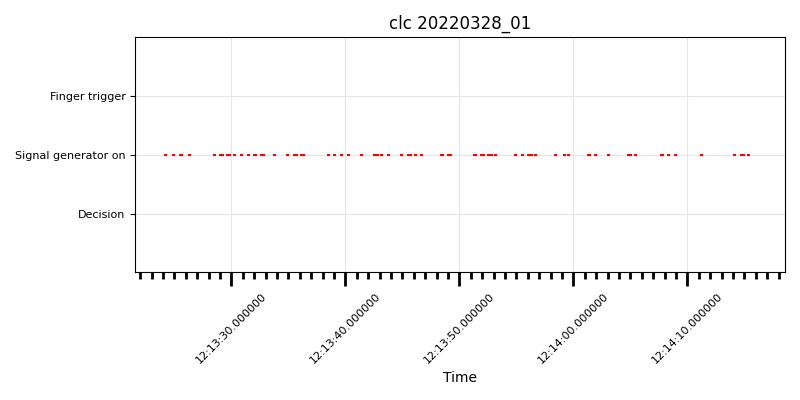

In [11]:
%matplotlib notebook
# get data for each animal

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=1)
tick_minutes_fmt = mdates.DateFormatter('%H:%M:%S.%f')
tick_minor = mdates.SecondLocator(interval=1)

# 
dict_dio_out = {}


# list dio
list_dio = [2, 1, 7,]

y_label = ['Decision', 
           'Signal generator on', 
           'Finger trigger'
            ]

# plot each session
curr_group = 'clc'
list_animals = dict_list_animals.get(curr_group)
for animal_id in list_animals:
    
    
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all, 
                                        experiment_name, trodes_version=2)

    cls_behavior.filter_animals(animal_id)

    print(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    if not dict_rewards:
        continue


    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False, 
                                               output_raw=False, 
                                               filter_retrigger=None)
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False, 
                                         output_raw=False, 
                                         filter_retrigger=filter_retrigger)

    # get unique sessions
    sessions_unique = np.sort(df_pump['session'].unique())
    print(sessions_unique)
    

    
    n_subplots = len(sessions_unique)
    
    
    fig = plt.figure(figsize=(8, n_subplots*2+2))
    axs = fig.subplots(n_subplots, 1)
    
    if n_subplots == 1:
        axs = [axs, ]
        sessions_unique = [sessions_unique[0], ]
    
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):

       
        # get session times
        
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        
        # get sensor and pump times
        try:
            df_sensor_curr = df_sensor[df_sensor['session']==session]
            df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start) 
                                           & (df_sensor_curr['on_time_sys']<curr_end)]
        except:
            pass
        
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start) 
                                       & (df_pump_curr['on_time_sys']<curr_end)]

        
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        
        for i, d in enumerate(list_dio):
            #print(d)
            
            yval = i+1
            
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            #print(curr_pump_name)
            #display(df_plot_pump)
            
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            
            try:
                df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]

                # plot well triggers
                for ind, row in df_plot_sensor.iterrows():
                    ax.scatter(row['on_time_sys'], yval, s=25, c='k')
            except:
                pass

            for ind, row in df_plot_pump.iterrows():
                try:
                    ax.plot([row['on_time_sys'], 
                              row['off_time_sys']], [yval, yval], c='r')
                except:
                    pass
                
                
            
        
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(y_label)

        ax.xaxis.set_major_formatter(tick_minutes_fmt)
        ax.xaxis.set_minor_locator(tick_minor)
        
        ax.tick_params(axis='x', labelrotation=45, length=10, width=2)
        ax.tick_params(axis='x', which='minor', length=5, width=2)
        ax.tick_params(axis='both', labelsize=8)
        ax.set_xlabel('Time')

        ax.set_title((f'{animal_id} {session}'))
        ax.set_ylim([0, 4])

        ax.grid(c=[.9, .9, .9])
        ax.set_axisbelow(True)

    plt.tight_layout()
    
    
    #fig_name = (f"{dir_fig}Phase{experiment_phase}_DIO_{animal_id}_per_session.pdf")
    #plt.savefig(fig_name)
        
 

## Plot the signal and DIO events

<IPython.core.display.Javascript object>


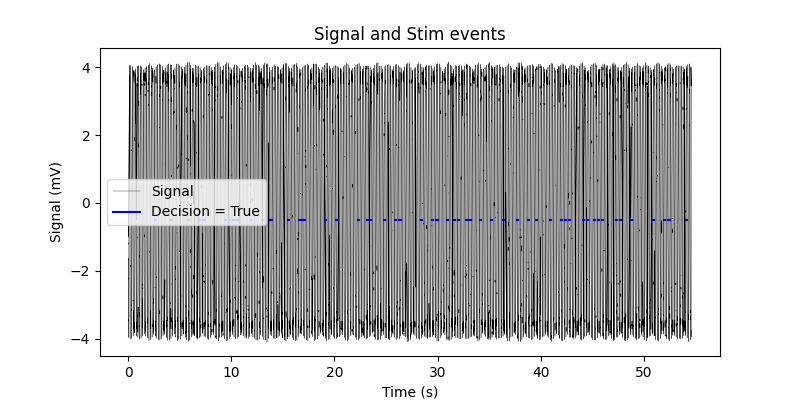

/media/nvme0/Analysis/clc/Results/laser_on_times_clc_20220328_01.xlsx


In [12]:
%matplotlib notebook
plt.figure(figsize=(8, 4))

dict_data_save = {}

down_sample = 10


for n, t in enumerate(tlist):
    x = time_data[::down_sample] - time_data[0]
    
    for i in [0,]:
        y = dict_data.get(t).get('raw')[i][::down_sample]
        plt.plot(x/30000, y/1000+i*0.1+n, lw=0.25, c='k', label='Signal')
    
    dict_data_save.update({t: {'timestamp': x,
                          'data': y}})
        
yval = -.5

curr_dio = dict_dio_out.get(int(fname_epoch))

for ind, row in curr_dio.iterrows():
    
    if row['dio'] == 'decision_pump':
        
        plt.plot([(row['on_time'] - time_data[0])/30000, 
                  (row['off_time'] - time_data[0])/30000], 
                 [yval+.15, yval+.15], c='r')
        
#         signal_on_time.append((row['on_time'] - time_data[0])/30000)
#         signal_off_time.append((row['off_time'] - time_data[0])/30000)
        
    if row['dio'] == 'signal_pump':
        plt.plot([(row['on_time'] - time_data[0])/30000, 
                  (row['off_time'] - time_data[0])/30000], 
                 [yval, yval], c='b')
        
#         hardware_on_time.append((row['on_time'] - time_data[0])/30000)
#         hardware_off_time.append((row['off_time'] - time_data[0])/30000)

# legend placeholder
#plt.plot([0], [0], c='r', label='Algorithm decision = True')
plt.plot([0], [0], c='b', label='Decision = True')
plt.legend()
# plt.ylim([-.7, .8])
plt.xlabel('Time (s)')
plt.ylabel('Signal (mV)')
plt.title('Signal and Stim events')
                    
        
# save data as csv
out_dio_fname = f'laser_on_times_{fname_exp}_{fname_date}_{fname_epoch}'

curr_dio_out = curr_dio[['on_time', 'off_time']]
curr_dio_out_fname = f'{dir_fig}{out_dio_fname}.xlsx'
print(curr_dio_out_fname)
curr_dio_out.to_excel(curr_dio_out_fname, index=False)

for k, v in dict_data_save.items():
    data_save_fname = f'tetrode_recording_{fname_exp}_{fname_date}_{fname_epoch}_tet{k}'
    for kk, vv in v.items():
        data_save_path = f'{dir_fig}{data_save_fname}_{kk}.csv'
        
        with open(data_save_path, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(vv)




## Average before and after light on or off

In [13]:
# this will find all the decision on events and get the indices for a window around the event
event_type = 'on_time'
#event_type = 'off_time'
window = 1
fs = 30000

curr_dio = dict_dio_out.get(int(fname_epoch))
list_win_ind = []
for ind, row in curr_dio.iterrows():
    
    if row['dio'] != 'decision_pump':
        continue
    
    # on/off
    curr_event = row[event_type]
    
    # get indices for current event
    curr_event_ind = np.argmax(time_data >= curr_event)
    
    #print(curr_event_ind)
    
    # get current window
    curr_win = [curr_event_ind - int(window*fs), curr_event_ind + int(window*fs)]
    
    list_win_ind.append(curr_win)


## Plot the raw signals around the events

<IPython.core.display.Javascript object>


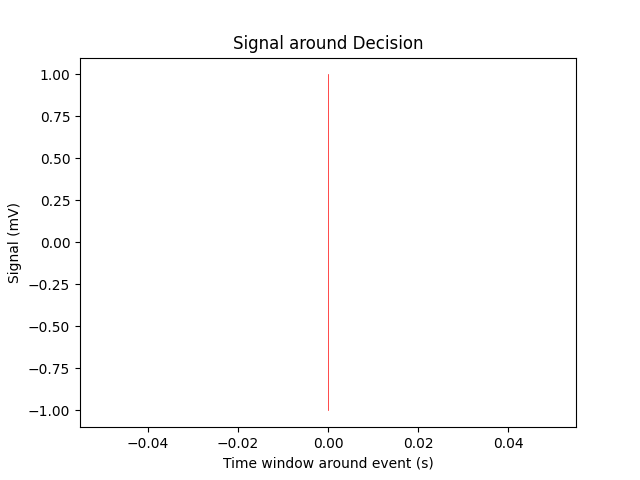

Text(0.5, 1.0, 'Signal around Decision')

In [14]:
# plot

plt.figure()

x = np.arange(-window, window, 1/fs)

plt.plot([0, 0], [-1, 1], c='r', lw=0.5)

for n, t in enumerate(tlist):
    for i in [1, ]:
        y = dict_data.get(t).get('raw')[i] 
        [plt.plot(x, y[v[0]:v[1]]/1000+i*0.1+n, lw=0.5, c='k', alpha=.2) for v in list_win_ind]
        
plt.xlabel('Time window around event (s)')
plt.ylabel('Signal (mV)')
plt.title('Signal around Decision')


## Algorithm performance

In [23]:
from scipy.signal import sosfiltfilt, butter, hilbert

In [16]:
time_aligned = (np.array(time_data) - time_data[0])/30000
raw_data = dict_data.get(t).get('raw')[0]

target_lowcut = 4
target_highcut = 10
sampling_rate = 30000
buffer_size = 200

butter_filter = butter(1, [target_lowcut, target_highcut], 'bp', fs=sampling_rate, output='sos')
filtered_data = sosfiltfilt(butter_filter,raw_data)
filtered_envelope = np.abs(hilbert(filtered_data))

<IPython.core.display.Javascript object>


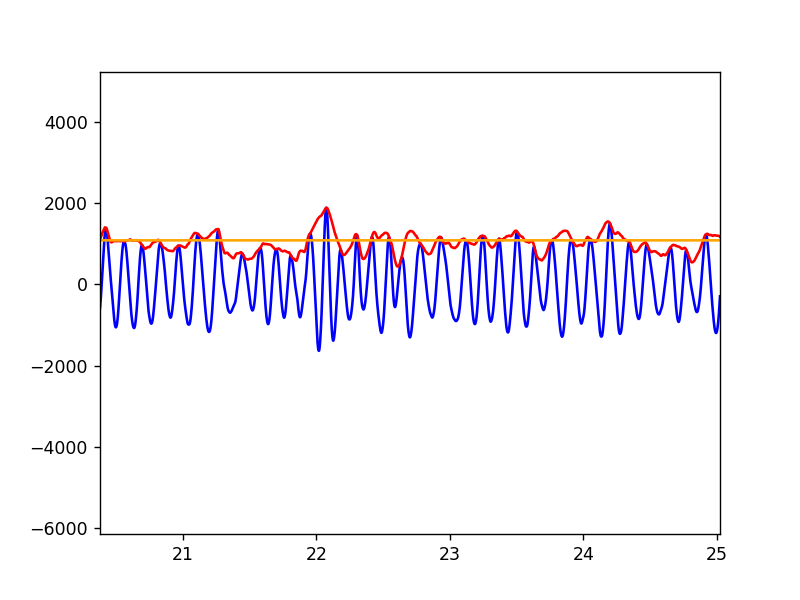

In [17]:
%matplotlib notebook

plt.plot(time_aligned, filtered_data, c='b')
plt.plot(time_aligned, filtered_envelope, c='r')
plt.plot(time_aligned,[np.mean(filtered_envelope)-0*np.std(filtered_envelope)]*len(time_aligned), c='orange')

In [18]:
bar = np.mean(filtered_envelope) + 0.5*np.std(filtered_envelope)
index_in = np.array(filtered_envelope) > bar

### Critical points

In [27]:
def generate_matrix(regr_buffer_size):
    sampling_axis = np.arange(regr_buffer_size)
    A = np.vstack([sampling_axis, np.ones(len(sampling_axis))]).T
    return A


def calculate_derv(A, buffer):
    curr_regr = buffer[:, np.newaxis]
    pinv = np.linalg.pinv(A)
    alpha = pinv.dot(curr_regr)
    return alpha[0][0]


def critical_point(derivative_history,time,regr_buffer_size,index_in,num_to_wait=5):
    
    critical_time = []
    current_sign = True
    sign_buffer = []

    for i in range(len(derivative_history)):
        if i == 0:
            current_sign = (derivative_history[0]>0)
            sign_buffer = [derivative_history[0]>0]*num_to_wait
            continue

        sign_buffer.append(derivative_history[i]>0)
        sign_buffer.pop(0)

        flip = True
        for sign in sign_buffer:
            if current_sign == sign:
                flip = False
                break

        if flip & index_in[i+int(regr_buffer_size/2)-num_to_wait]:
            critical_time.append(time[i+int(regr_buffer_size/2)-num_to_wait])
            current_sign = sign_buffer[-1]
    
    return np.array(critical_time)

In [20]:
derivative_history = []

A = generate_matrix(buffer_size)

for i in range(buffer_size,len(filtered_data)):
    curr_buffer = filtered_data[i-buffer_size:i]
    curr_derv = calculate_derv(A,curr_buffer)
    derivative_history.append(curr_derv)

In [28]:
critical_points = critical_point(derivative_history,time_aligned,buffer_size,index_in,num_to_wait=3)

<IPython.core.display.Javascript object>


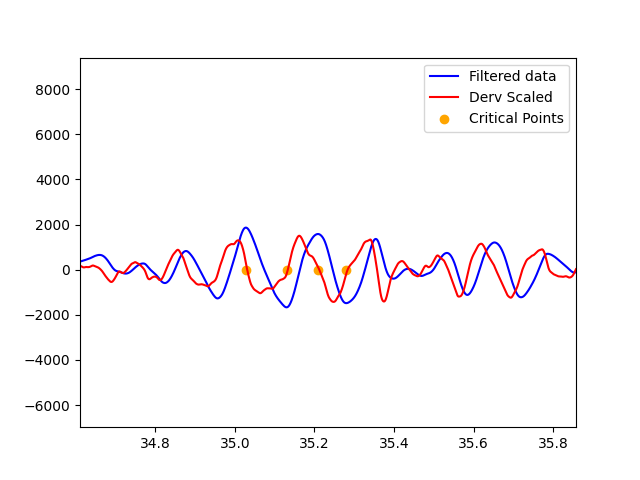

In [30]:
%matplotlib notebook

plt.plot(time_aligned,filtered_data,c='b', label='Filtered data')
plt.plot(time_aligned[buffer_size:],np.array(derivative_history)*600,c='r',label='Derv Scaled')
plt.scatter(critical_points,[0]*len(critical_points),c='orange', label='Critical Points')
plt.legend()

<IPython.core.display.Javascript object>


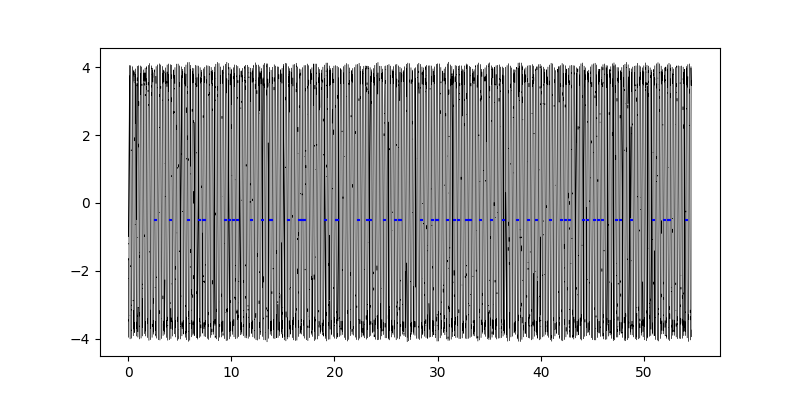

NameError: name 'critical_points' is not defined

In [55]:
%matplotlib notebook
plt.figure(figsize=(8, 4))

dict_data_save = {}

down_sample = 10


for n, t in enumerate(tlist):
    x = time_data[::down_sample] - time_data[0]
    
    for i in [0,]:
        y = dict_data.get(t).get('raw')[i][::down_sample]
        plt.plot(x/30000, y/1000+i*0.1+n, lw=0.25, c='k', label='Signal')
    
    dict_data_save.update({t: {'timestamp': x,
                          'data': y}})
        
yval = -.5

hardware_on_time = []

curr_dio = dict_dio_out.get(int(fname_epoch))

for ind, row in curr_dio.iterrows():
    
    if row['dio'] == 'decision_pump':
        
        plt.plot([(row['on_time'] - time_data[0])/30000, 
                  (row['off_time'] - time_data[0])/30000], 
                 [yval+.15, yval+.15], c='r')
                
    if row['dio'] == 'signal_pump':
        plt.plot([(row['on_time'] - time_data[0])/30000, 
                  (row['off_time'] - time_data[0])/30000], 
                 [yval, yval], c='b')
        
        hardware_on_time.append((row['on_time'] - time_data[0])/30000)

plt.scatter(critical_points,[0]*len(critical_points),c='orange',s=3,label='Critical point')
plt.plot(time_aligned,filtered_data/1000,c='r')

# legend placeholder
#plt.plot([0], [0], c='r', label='Algorithm decision = True')
# plt.plot([0], [0], c='b', label='Decision = True')
# plt.legend()
# plt.ylim([-.7, .8])
# plt.xlabel('Time (s)')
# plt.ylabel('Signal (mV)')
# plt.title('Signal and Stim events')
                    
        
# save data as csv
out_dio_fname = f'laser_on_times_{fname_exp}_{fname_date}_{fname_epoch}'

curr_dio_out = curr_dio[['on_time', 'off_time']]
curr_dio_out_fname = f'{dir_fig}{out_dio_fname}.xlsx'
print(curr_dio_out_fname)
curr_dio_out.to_excel(curr_dio_out_fname, index=False)

for k, v in dict_data_save.items():
    data_save_fname = f'tetrode_recording_{fname_exp}_{fname_date}_{fname_epoch}_tet{k}'
    for kk, vv in v.items():
        data_save_path = f'{dir_fig}{data_save_fname}_{kk}.csv'
        
        with open(data_save_path, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(vv)

### Lag

In [32]:
%matplotlib notebook

detection_start = 0
for i in range(len(critical_points)):
    if critical_points[i]<hardware_on_time[0] and critical_points[i+1]>hardware_on_time[0]:
        detection_start = i
        break

on_lags = [(time_2-time_1) for time_1 in np.array(critical_points[detection_start:])*(10**3) \
           for time_2 in np.array(hardware_on_time)*(10**3)]  

<IPython.core.display.Javascript object>


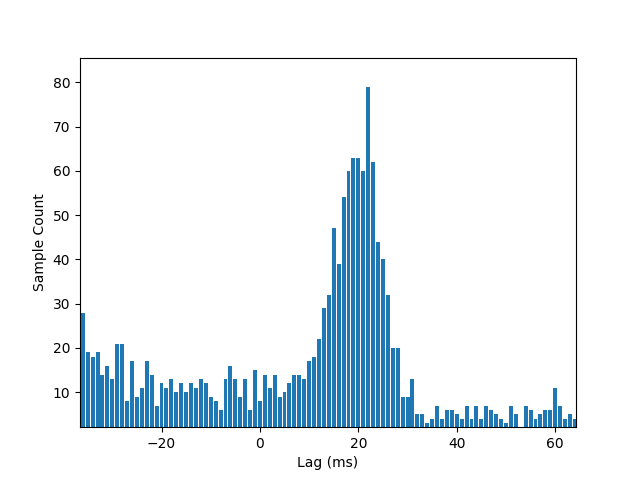

Text(0.5, 0, 'Lag (ms)')

In [33]:
%matplotlib notebook
on_xcorr_hist,on_bin_edges = np.histogram(on_lags,range(-1000,1000))
plt.bar(on_bin_edges[:-1],on_xcorr_hist)
plt.ylabel('Sample Count')
plt.xlabel('Lag (ms)')

### Accuracy & Precision

In [46]:
hit = 0
for critical in critical_points:
    for hardware in hardware_on_time:
        if 0 < (hardware-critical) < 0.030:
            hit+=1
            break

In [47]:
hit/len(critical_points)

0.7640545144804088

In [ ]:
precise = 0
for hardware in hardware_on_time:
    for critical in critical_points:
        if 0 < (hardware-critical) < 0.030:
            precise+=1
            break

In [ ]:
precise/len(hardware_on_time)

## Algorithm history

In [15]:
# data_file = '/media/nvme0/Data/clc/data/raw_PhaseGen_01.txt'
data_file_1 = '/media/nvme0/Data/clc/data/derv_PhaseGen_04.txt'
data_file_2 = '/media/nvme0/Data/clc/data/derv_PhaseGen_06.txt'
data_file_3 = '/media/nvme0/Data/clc/data/phase_PhaseGen_01.txt'

# derv_PhaseGen_01, 02, 03 correspond to regr_buffer_size = 20, 100, 200
# derv_PhaseGen_04, 05 correspond to pseudoinverse method, regr_buffer_size = 200, 100
# derv_PhaseGen_06 correspond to modularized pinv derv method, regr_buffer_size = 200
# phase_PhaseGen_01 corresponds to the testing of linear phase interpolation

In [16]:
def process_txt(data_file):
    with open(data_file,'r') as f:
        lines = f.readlines()
    even_len = len(lines)-(len(lines)%2)
    
    data = []
    time = []
    for i in range(even_len):
        curr_val = lines[i]
        if i%2 == 0:
            try:
                data.append(float(curr_val[:-1]))
            except ValueError:
                pass
        else:
            time.append(int(curr_val[:-1]))
        
    data = np.array(data)
    time = np.array(time)
    
    return data, time

In [17]:
# data_1, time_1 = process_txt(data_file_1)
# data_2, time_2 = process_txt(data_file_2)
# time_2 = np.array([t-(time_2[0]-time_1[0]) for t in time_2])

In [18]:
phase_data, time = process_txt(data_file_3)

In [19]:
time_aligned = (time-time[0])*10**(-9)

<IPython.core.display.Javascript object>


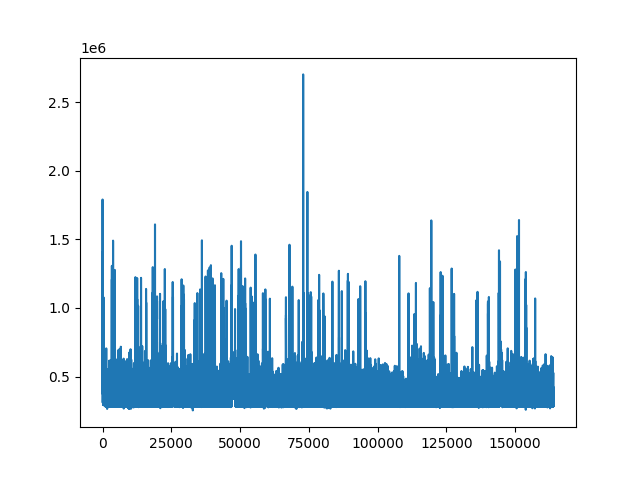

In [20]:
%matplotlib notebook

# the timestamps recorded by time module may not be reliable. While the timestamps should be evenly
# spaced out, the actual timestamp intervals vary a lot

# plt.plot(time)
plt.plot(np.diff(time))
# plt.plot(np.diff(time_2))

<IPython.core.display.Javascript object>


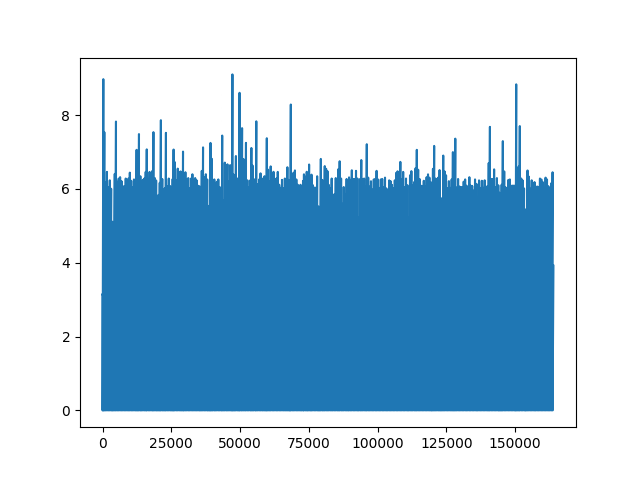

In [21]:
% matplotlib notebook

plt.plot(phase_data)

<IPython.core.display.Javascript object>


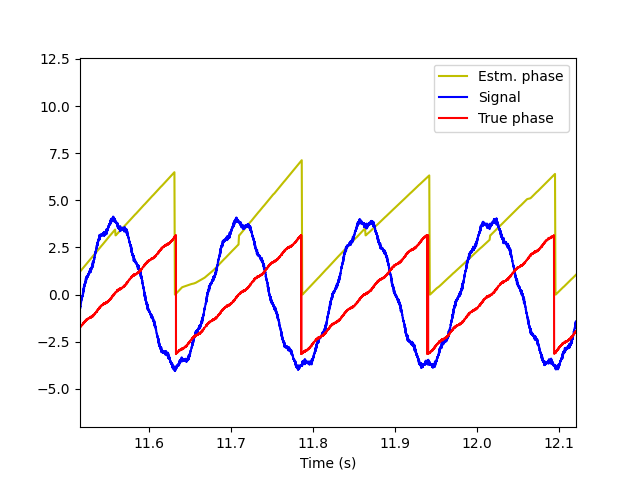

In [26]:
%matplotlib notebook

# plt.scatter(time,data,s=4,color='r')
# plt.plot(time_2, data_2,color='b')
# plt.plot(time_1, data_1, color='r')

# plt.plot(time[5:],phase_data)
# plt.plot((time_data-time_data[0]),y)

signal = dict_data.get(t).get('raw')[0]/1000
true_phase = np.angle(hilbert(signal))
plt.plot(time_aligned[5:]+0.03,phase_data,c='y',label='Estm. phase')
# plt.plot(0.09+np.arange(len(phase_data))/2800,phase_data,c='y')
plt.plot((time_data-time_data[0])/30000,signal,c='b',label='Signal')
plt.plot((time_data-time_data[0])/30000,true_phase,c='r',label='True phase')
plt.xlabel('Time (s)')
plt.legend()